In [17]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 300.6 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


1. Predict Whether a Product Will Be a Top Seller (Classification)
	•	Target: IsTopSeller (Yes / No)
	•	Use Case: Predict which products are likely to become top-sellers based on cost, discount, season, etc.
    •	Model Suggestions:
	    •  Logistic Regression 
    	•	Metric: Accuracy, F1 Score


💡 Business Impact: Helps the business identify potential top-selling products early, optimize inventory, and plan promotions.

   1. load and split the data

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split

df=pd.read_csv('/Users/krutikakatke/Documents/fashion-business-analyst-AI/Data/train_ready_dataset.csv')
X = df.drop('IsTopSeller', axis=1)
y = df['IsTopSeller']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Base model logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        50
           1       0.94      0.94      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100

[[47  3]
 [ 3 47]]


Improve with Random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



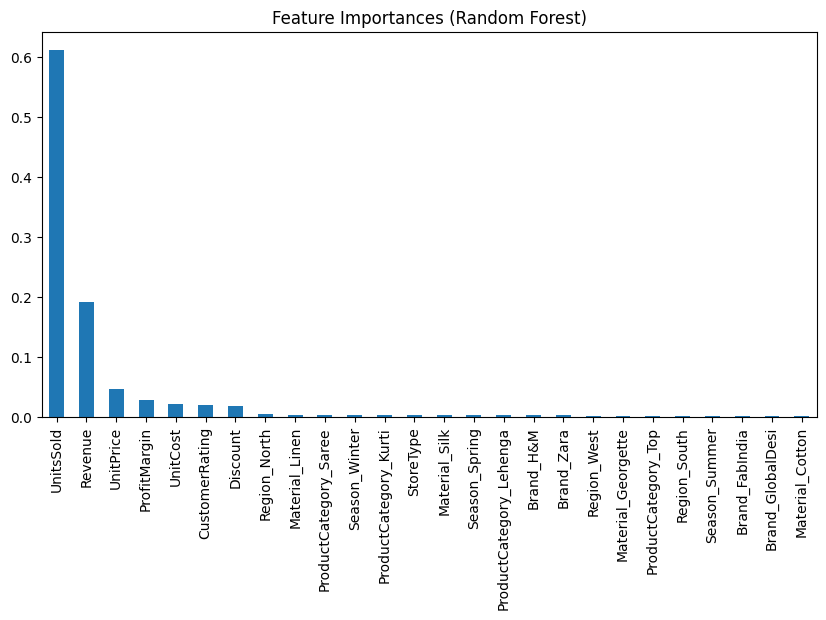

In [34]:
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title('Feature Importances (Random Forest)')
plt.show()

Optimize with XGBoost (best model)

In [35]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



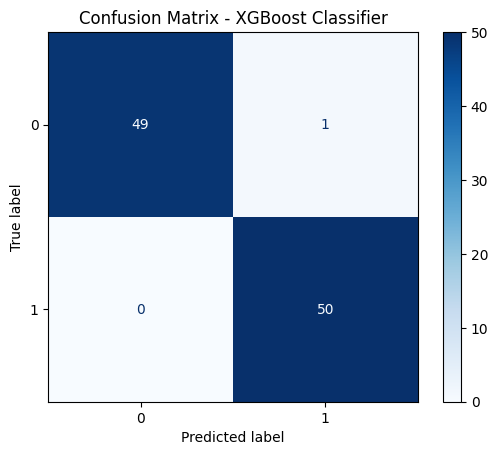

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()

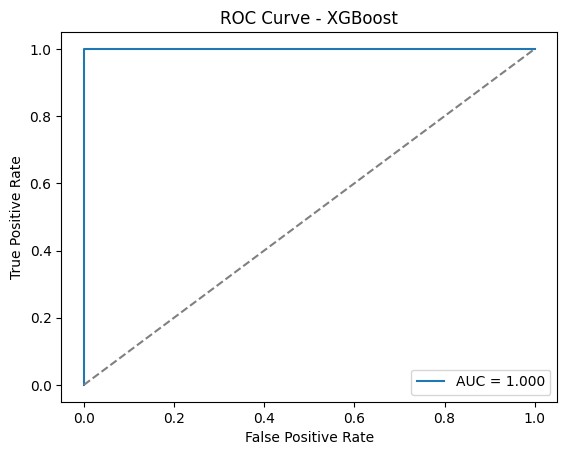

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = xgb.predict_proba(X_test)[:, 1]  # probability of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.show()

In [38]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracies:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-validation accuracies: [1.   1.   1.   0.99 0.98]
Mean CV Accuracy: 0.9940000000000001


In [39]:
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "XGBoost": xgb
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {acc:.3f}")

Logistic Regression: Accuracy = 0.940
Random Forest: Accuracy = 0.990
XGBoost: Accuracy = 0.990


After running all the above:
	•	Confusion matrix → what your model gets right/wrong.
	•	ROC curve → model confidence visualization.
	•	AUC score & CV accuracy → overall performance stability.
	•	Feature importance chart → business insights.
	•	Final chosen model (XGBoost, most likely).

now as the model has 0.990 accuracy so we dont need to do model optimization.
we can just save our trained model now

In [40]:
import joblib

# Save trained model
joblib.dump(xgb, 'xgb_top_seller_model.pkl')

['xgb_top_seller_model.pkl']

In [41]:
model = joblib.load('xgb_top_seller_model.pkl')


In [42]:
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred) 

print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)

Training Accuracy: 0.9975
Testing Accuracy: 0.99


In [43]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validation scores: [1.   1.   1.   0.99 0.98]
Mean CV accuracy: 0.9940000000000001
